In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import plotly.graph_objects as go

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "vscode"


# PROBLEM 1

I remember being asked by my High Schoool Maths teacher this question in 2017 and thinking about it for days. Now it is 2024 and although I have not attempted to solve this with pencil and paper maths, I now know how to code and will brute force the problem. An inspiring solution...

**RULES:**
- There is a square field of side length 1.
- In the top left corener there is a farmer.
- In the bottom left corner there is a bull.
- The farner has to get to the bottom right corner (and follows a direct path striaght for the bottom right corner).
- When the bull is running it always runs in a direction towards the farmer. 



## QUESTION 1
If the bull and farmer set off at the same time, how much faster does the farmer need to run to be in the clear.

## QUESTION 2
If the bull and farmer run at the same speed, how far must the farmer before the bull notices and starts to run. 

# Setting intial parameters

In [103]:
FIELD_LENGTH = 1

FARMER_SPEED = 1
BULL_SPEED = 1
BULL_DELAY = 0

DT = 1e-3
BULL_HIT_PRECISION = FIELD_LENGTH/500 # if the bull is within 1% it is a catch

START_FARMER_COORD = np.array([0, FIELD_LENGTH])
END_FARMER_COORD = np.array([FIELD_LENGTH, 0])
START_BULL_COORD = np.array([0, 0])




In [104]:
def distance_between(coord1, coord2):

    return np.sqrt(np.sum((coord1 - coord2)**2))


def is_farmer_caught(distance, precision):
    if distance <= precision:
        return True
    else:
        return False
    

def get_direction(current_coord, destination_coord):
    return destination_coord - current_coord


def update_coord(current_coord, destination_coord, speed, dt):

    direction = get_direction(current_coord, destination_coord)
    d_hat = direction / np.linalg.norm(direction)
    dist = d_hat * speed * dt

    return current_coord +   dist



# set up initial dictionary of parameters 
simulation_parameters = {
    'FIELD_LENGTH': FIELD_LENGTH,
    'FARMER_SPEED': FARMER_SPEED,
    'BULL_SPEED': BULL_SPEED,
    'BULL_DELAY': BULL_DELAY,
    'DT': DT,
    'BULL_HIT_PRECISION': BULL_HIT_PRECISION,
    'START_FARMER_COORD': START_FARMER_COORD,
    'END_FARMER_COORD': END_FARMER_COORD,
    'START_BULL_COORD': START_BULL_COORD,
}



In [105]:
def run_farmer_bull_simulation(simulation_parameters):
    distance_farmer_to_run = distance_between(simulation_parameters['START_FARMER_COORD'], simulation_parameters['END_FARMER_COORD'])
    total_farmer_run_time = distance_farmer_to_run/simulation_parameters['FARMER_SPEED']
    caught_farmer = False
    bull_start = False

    total_time_points = int(total_farmer_run_time / simulation_parameters['DT'])

    new_farmer_coord = simulation_parameters['START_FARMER_COORD']
    new_bull_coord = simulation_parameters['START_BULL_COORD']

    farmer_coords = np.zeros((total_time_points, 2))
    bull_coords = np.zeros((total_time_points, 2))

   

    for time_index in range(total_time_points):

        # if farmer is caught end loop
        caught_farmer = is_farmer_caught(distance_between(new_farmer_coord, new_bull_coord), simulation_parameters['BULL_HIT_PRECISION'])
        if caught_farmer:
            # print('caught')
            break

        # update farmer position
        new_farmer_coord = update_coord(new_farmer_coord, simulation_parameters['END_FARMER_COORD'], simulation_parameters['FARMER_SPEED'], simulation_parameters['DT'])

        # check if bull should start running
        if not bull_start:
            if simulation_parameters['BULL_DELAY'] <= simulation_parameters['DT'] * time_index:
                bull_start = True
        
        # update bull coordinate if it should start running
        if bull_start:
            new_bull_coord = update_coord(new_bull_coord, new_farmer_coord, simulation_parameters['BULL_SPEED'], simulation_parameters['DT'])

        
        farmer_coords[time_index] = new_farmer_coord
        bull_coords[time_index] = new_bull_coord
    

    zero_removal = np.where(bull_coords == 0)

    percent_time = (time_index / total_time_points ) * 100


    return farmer_coords[~np.all(bull_coords == 0, axis=1)], bull_coords[~np.all(bull_coords == 0, axis=1)], caught_farmer, percent_time



# Plot animation of Farmer vs Bull

In [133]:
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

# plt.style.use('dark_background')
# plt.style.use('default')
plt.style.use('Solarize_Light2')


In [139]:
farmer_coords, bull_coords, caught_farmer, percent_time = run_farmer_bull_simulation(simulation_parameters)

master_dict = {}

caught_farmer_list = []
num_bull_animations = 50
bull_speeds = np.linspace(0.5, 4, num_bull_animations)
# bull_speeds = np.linspace(1, 1.5, num_bull_animations)

for index, bull_speed in enumerate(bull_speeds):

    # print(f'Starting loop number {index + 1}')

    simulation_parameters = {
    'FIELD_LENGTH': FIELD_LENGTH,
    'FARMER_SPEED': FARMER_SPEED,
    'BULL_SPEED': bull_speed,
    'BULL_DELAY': BULL_DELAY,
    'DT': DT,
    'BULL_HIT_PRECISION': BULL_HIT_PRECISION,
    'START_FARMER_COORD': START_FARMER_COORD,
    'END_FARMER_COORD': END_FARMER_COORD,
    'START_BULL_COORD': START_BULL_COORD,
}
    
    farmer_coords, bull_coords, caught_farmer, percent_time = run_farmer_bull_simulation(simulation_parameters)

    if index == 0:
        master_dict['farmer'] = [farmer_coords[:, 0], farmer_coords[:, 1]]

    master_dict[f'bull_{bull_speed:.2f}'] = [bull_coords[:, 0], bull_coords[:, 1]]
    caught_farmer_list.append(caught_farmer)


frame_num = np.shape(master_dict['farmer'])[1]
num_frames = np.shape(master_dict['farmer'])[1]


# Create a figure and axis
fig = plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))  # Set the figure to be square
# ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot([], [], lw=2)

# fig.set_facecolor("white")


bull_colour = ['red' if caught else 'green' for caught in caught_farmer_list]
plotlays = [2]
plotcols = ["black"] + bull_colour
lines = []

for index in range(num_bull_animations + 1):
    lobj = ax.plot([],[],lw=2,color=plotcols[index])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines


def animate(i):
    xlist, ylist = [], []

    for key, val in master_dict.items():
        xlist.append(val[0][:i])
        ylist.append(val[1][:i])

    for lnum, line in enumerate(lines):
            line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 

    return lines

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

fontsize = 16
caught_speed = (bull_speeds[caught_farmer_list][0]) * 100
escape_speed = (bull_speeds[np.logical_not(caught_farmer_list)][-1]) * 100
plt.text(0.38, 0.83, 'Farmer', fontsize = fontsize, color = 'black')
plt.text(0.38, 0.73, f'Farmer Caught:\nBull relative speed > +{caught_speed:.0f}%', fontsize = fontsize, color = 'red')
plt.text(0.38, 0.63, f'Farmer Escapes:\nBull relative speed < +{escape_speed:.0f}%', fontsize = fontsize, color = 'green')

ax.annotate(f'Relative bull speed\nMax = {((bull_speeds[-1] - 1) * 100):.0f}%', xy=(0.15, 0.85),
            fontsize=fontsize,
             xycoords='data',
             xytext=(0.12, 0.9),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='red',
                             lw=3.5,
                             ls='--')
           )


ax.annotate(f'Relative bull speed\nMinimum = {((bull_speeds[0] - 0) * 100):.0f}%', xy=(0.1, 0.28),
            fontsize=fontsize,
             xycoords='data',
             xytext=(0.1, 0.05),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='green',
                             lw=3.5,
                             ls='--')
           )

ax.grid(False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')
fig.tight_layout()
adjust_val = -0.01
fig.subplots_adjust(left=0-adjust_val, right=1+adjust_val, top=1+adjust_val, bottom=0-adjust_val)  # Remove padding

linewidth = 5
ax.axhline(y=0, color='k', linewidth=linewidth)
ax.axvline(x=0, color='k', linewidth=linewidth)
ax.axhline(y=1, color='k', linewidth=linewidth)
ax.axvline(x=1, color='k', linewidth=linewidth)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(0,frame_num,25), interval=100, blit=True)


# writervideo = animation.FFMpegWriter(fps=30, codec='mpeg4')
# anim.save('increasingStraightLine.mp4') # save as mp4

anim.save('Farmer-vs-Bull.gif', writer='imagemagick', dpi=200) # save as gif

plt.close() 


MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

# Answer Question 1

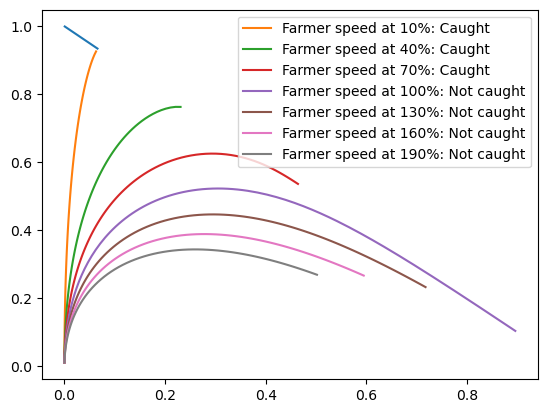

In [177]:
for index, farmer_speed in enumerate(np.arange(0.1, 2, 0.3)):

    simulation_parameters = {
    'FIELD_LENGTH': FIELD_LENGTH,
    'FARMER_SPEED': farmer_speed,
    'BULL_SPEED': BULL_SPEED,
    'BULL_DELAY': BULL_DELAY,
    'DT': DT,
    'BULL_HIT_PRECISION': BULL_HIT_PRECISION,
    'START_FARMER_COORD': START_FARMER_COORD,
    'END_FARMER_COORD': END_FARMER_COORD,
    'START_BULL_COORD': START_BULL_COORD,
}
    
    farmer_coords, bull_coords, caught_farmer, percent_time = run_farmer_bull_simulation(simulation_parameters)

    if index == 0:
        plt.plot(farmer_coords[:, 0], farmer_coords[:, 1])

    
    bull_caught_txt = 'Not caught'
    if caught_farmer:
        bull_caught_txt = 'Caught'

    plt.plot(bull_coords[:, 0], bull_coords[:, 1], label=f'Farmer speed at {simulation_parameters['FARMER_SPEED']*100:0.0f}%: {bull_caught_txt}')

plt.legend()

# Answer Question 2

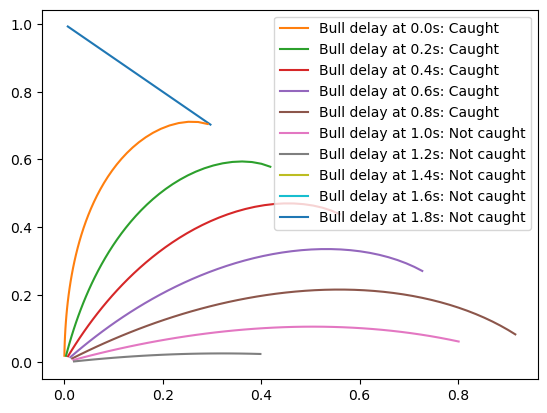

In [178]:
for index, bull_delay in enumerate(np.arange(0, 2, 0.2)):

    simulation_parameters = {
    'FIELD_LENGTH': FIELD_LENGTH,
    'FARMER_SPEED': FARMER_SPEED,
    'BULL_SPEED': FARMER_SPEED*2,
    'BULL_DELAY': bull_delay,
    'DT': DT,
    'BULL_HIT_PRECISION': BULL_HIT_PRECISION,
    'START_FARMER_COORD': START_FARMER_COORD,
    'END_FARMER_COORD': END_FARMER_COORD,
    'START_BULL_COORD': START_BULL_COORD,
}
    
    farmer_coords, bull_coords, caught_farmer, percent_time = run_farmer_bull_simulation(simulation_parameters)

    if index == 0:
        plt.plot(farmer_coords[:, 0], farmer_coords[:, 1])

    
    bull_caught_txt = 'Not caught'
    if caught_farmer:
        bull_caught_txt = 'Caught'

    plt.plot(bull_coords[:, 0], bull_coords[:, 1], label=f'Bull delay at {simulation_parameters['BULL_DELAY']:.1f}s: {bull_caught_txt}')

plt.legend()

# Above and beyond

Let's get a little fancy and have a look at the 'functional orm' of delay vs. speed.
Here we will plot a plane where the z dimension percentage of total time farmer take to cross the field in which they got caught. 
i.e. if the farmer only made it 10% of the way this will be a 10% in time. 
Let us assume that 100% means the farmer did not get caught.

In [211]:
delay_range = np.arange(0, 5, 0.05)
speed_range = np.arange(0.01, 1.1, 0.05)

DT = 1e-2

X, Y = np.meshgrid(delay_range, speed_range)
Z = np.zeros((np.shape(X)))

for i, bull_delay in enumerate(delay_range):
    for j, farmer_speed in enumerate(speed_range):

        simulation_parameters = {
    'FIELD_LENGTH': FIELD_LENGTH,
    'FARMER_SPEED': farmer_speed,
    'BULL_SPEED': FARMER_SPEED,
    'BULL_DELAY': bull_delay,
    'DT': DT,
    'BULL_HIT_PRECISION': BULL_HIT_PRECISION,
    'START_FARMER_COORD': START_FARMER_COORD,
    'END_FARMER_COORD': END_FARMER_COORD,
    'START_BULL_COORD': START_BULL_COORD,
}
         

        farmer_coords, bull_coords, caught_farmer, percent_time = run_farmer_bull_simulation(simulation_parameters)

        Z[j, i] = percent_time
    

In [ ]:
contours = {
        "x": {"show": True, "start": delay_range[0], "end": delay_range[-1], "size": 0.5, "color":"white"},
        "y": {"show": True, "start": speed_range[0], "end": speed_range[-1], "size": 0.2, "color":"white"},
        "z": {"show": True, "start": 0.0, "end": 100, "size": 10}
    }

hovertemplate = 'Bull Delay: %{x:.2f}'+\
                '<br>Farmer/Bull Speed: %{y:.2f}'+\
                '<br>Percent Time chasing Farmer: %{z:.0f}%<extra></extra>'

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, contours=contours, hovertemplate=hovertemplate)])


# Add titles and labels
fig.update_layout(
    title='Farmer vs. Bull in a field',
    width=1000, height=1000,
    scene=dict(
        xaxis_title='Bull Delay',
        yaxis_title='Farmer Speed / Bull Speed',
        zaxis_title='Percent time to catch Farmer',
        camera_eye= {"x": -1.5, "y": -1.5, "z": 0.8},
    ),
)

# Show the plot
# fig.show()

fig.write_html(f"farmer-vs-bull-variable.html")